### Objetivos del notebook
---

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting).

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene alrededor de **300 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**DIARIAS**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Es decir, partimos de ventas diarias y vamos a tener que <u>**agrupar nuestras ventas por mes**</u> antes de crear variables o entrenar el modelo.



### Índice
<a id='index'></a>

[Imports del notebook](#imports_notebook)<br>
[Helpers Time Series](#helpers)<br>
[Data Loading](#data_load)<br>
[La idea del modelo (**CORE IDEA**)](#benchmark)<br>
[Agrupación de las ventas por mes (**CORE IDEA**)](#monthly_agg)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**CORE IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [195]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.22.4
Pandas version 1.5.3
XGBoost version 1.7.5


In [198]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD)
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "ts_sales_train_merged.csv")

ORDER_COLUMNS = [
    'DATE',
    'UNIQUE_ID',
    'CITY_NAME',
    'CITY_ID',
    'SHOP_NAME',
    'SHOP_ID',
    'ITEM_CATEGORY_NAME',
    'ITEM_CATEGORY_ID',
    'ITEM_NAME',
    'ITEM_ID',
    'ITEM_PRICE',
    'SALES'
]

<a id='helpers'></a>
### Helpers Time Series
[Volver al índice](#index)

En este apartado definimos varias funciones auxiliares que utilizaremos a lo largo del notebook.

In [199]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    df = preprocess_df(df)
    
    return df

In [200]:
def preprocess_df(df):
    '''
    Preprocess df: upper columns, str date to datetime etc.
    '''
    df.columns = map(str.upper, df.columns)
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CITY_ID"] = OrdinalEncoder().fit_transform(df[["CITY"]])
    
    df.rename(columns = {"CITY":"CITY_NAME", "ITEM_CNT_DAY":"SALES"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [201]:
df = load_data(path_data_file = TRAIN_CSV_PATH)
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
23933,2013-12-14,16-20949,Kolomna,4.0,"centro comercial kolomna ""Río""",16,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,20.0
85714,2015-09-19,47-20949,Surgut,15.0,"Surgut SEC ""City Mall""",47,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,15.0
84950,2015-08-02,28-7893,Moscú,7.0,"centro comercial de Moscú ""MEGA Teply Stan"" II",28,Accesorios - XBOX 360,6,X360: GamePad Wireless Black - Controlador ina...,7893,2490.0,1.0
28636,2014-01-15,12-11373,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega a emisión (Boxberry),11373,342.0,2.0
81648,2015-07-14,55-7967,Tienda Online,16.0,El almacenamiento digital 1C-line,55,Las tarjetas de pago - en vivo! (Número),34,Xbox LIVE: Mapa de suscripción de oro 3 meses ...,7967,999.0,4.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87963 entries, 0 to 87962
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                87963 non-null  datetime64[ns]
 1   UNIQUE_ID           87963 non-null  object        
 2   CITY_NAME           87963 non-null  object        
 3   CITY_ID             87963 non-null  float64       
 4   SHOP_NAME           87963 non-null  object        
 5   SHOP_ID             87963 non-null  int64         
 6   ITEM_CATEGORY_NAME  87963 non-null  object        
 7   ITEM_CATEGORY_ID    87963 non-null  int64         
 8   ITEM_NAME           87963 non-null  object        
 9   ITEM_ID             87963 non-null  int64         
 10  ITEM_PRICE          87963 non-null  float64       
 11  SALES               87963 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 8.7+ MB


<a id='benchmark'></a>
### La idea del modelo (CORE IDEA)
[Volver al índice](#index)

A **grosso modo** vamos a hacer las siguientes cosas:

1. Ver cuantas Series Temporales tenemos en el dataset.
2. Hacer un check de si tenemos todas las fechas históricas en el dataset.
3. Generar las fechas que puedan estar missing.
4. Tratar los nulos.
5. Crear algunas variables rápidas para el entrenamiento.
6. Entrenar el algoritmo.
7. Evaluar el modelo.
8. Hacer el submit.

Empecemos:

Tenemos un total de 299 Series Temporales en el dataset:

In [203]:
df["UNIQUE_ID"].nunique()

299

Veamos cuales son las fechas min y max de nuestro dataset:

In [204]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [205]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-01 00:00:00
Max date is 2015-09-30 00:00:00


<a id='monthly_agg'></a>
### Agrupación de las ventas por mes
[Volver al índice](#index)

Nos piden que hagamos el predict de las ventas totales del mes de Octubre'2015 para cada ITEM_ID y SHOP_ID.

No obstante, si miramos el dataset con detenimiento, veremos que las ventas reportadas vienen por día. Ahora mismo tenemos 2 opciones: 

1. Podemos entrenar un modelo con las ventas diarias, predecir 30 días y luego sumar las 30 predicciones y obtener el valor para Octubre'2015.
2. Agrupar las ventas por mes, entrenar un modelo con las ventas mensuales y hacer 1 predict (mes de Octubre'2015).

Claramente la segunda opción es mucho más sencilla, por este motivo vamos a seguir este enfoque.

Nota: Si observamos bien, UNIQUE_ID = SHOP_ID + ITEM_ID.

In [206]:
df.sample(3)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
63217,2014-12-06,55-22166,Tienda Online,16.0,El almacenamiento digital 1C-line,55,Libros - Digital,54,Idioma de consulta 1c: Empresas [Versión digital],22166,150.0,2.0
33592,2014-03-28,25-13881,Moscú,7.0,"Moscú SEC ""Atrium""",25,Música - CD de la producción local,55,Leps GRIGORY LA MEJOR 3 CD (firmas.),13881,599.0,1.0
24352,2013-12-13,19-20949,Kursk,6.0,"Kursk TC ""Pushkin""",19,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,5.0


In [207]:
df[["UNIQUE_ID", "SHOP_ID", "ITEM_ID"]]

,UNIQUE_ID,SHOP_ID,ITEM_ID
0,25-2574,25,2574
1,25-2574,25,2574
2,25-2574,25,2574
3,25-2574,25,2574
4,25-2574,25,2574
...,...,...,...
87958,25-20949,25,20949
87959,25-20949,25,20949
87960,25-20949,25,20949
87961,25-20949,25,20949


In [208]:
df["UNIQUE_ID"].nunique()

299

A continuación vamos a agrupar las ventas diarias por mes, en función de cada shop_id e item_id (groupby).

Dado que vamos a entrenar nuestro modelo con variables mensuales, aprovechamos la operación para constuir un total de 5 variables: 

1. Ventas totales
2. Ingresos totales (precio x cantidad)
3. Días únicos que tuvieron ventas
4. Total transacciones del mes 
5. Precio medio del mes

In [209]:
df["REVENUE"] = df["ITEM_PRICE"] * df["SALES"]
df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
df["TOTAL_TRANSACTIONS"] = df["SALES"]

Cuando trabajamos con Series Temporales y necesitamos agrupar las Series Temporales por día, semana, mes o año, podemos utilizar el groupby pero es mejor utilizar el [pandas resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

La síntaxis del pandas resample es muy sencilla, vamos a ver un ejemplo de como podríamos agrupar las ventas por semana.

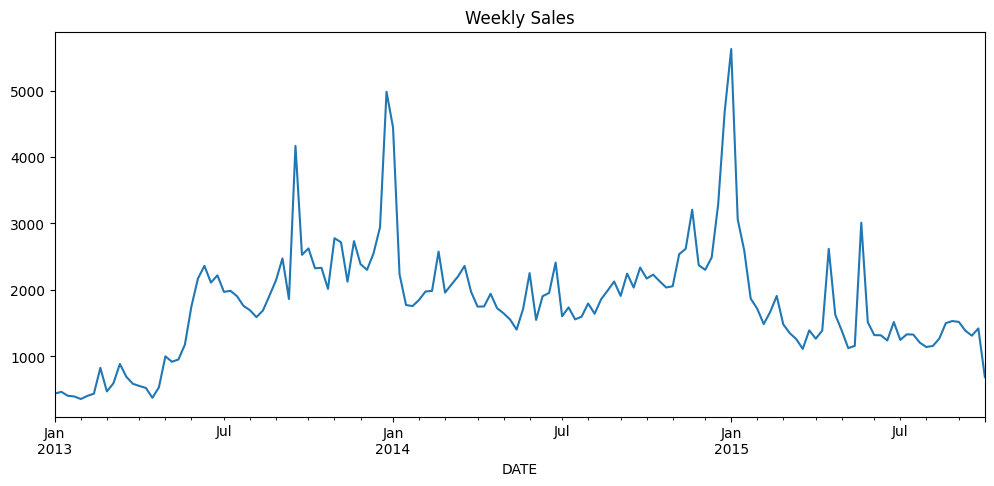

In [210]:
# Para utilizar el resample
# 1. La fecha debe estar en el índice
# 2. Debemos llamar el método resample y pasarle un regla:
#    D -> Daily
#    W -> Weekly
#    M -> Monthly
#    Y -> Yearly

df.set_index("DATE").resample("W")["SALES"].sum().plot(figsize = (12, 5), title = "Weekly Sales");

En el código anterior, hemos hecho el resample de todas las ventas.

Pero nosotros debemos tener en cuenta el item_id y el shop_id antes de hacer el resample.

Veamos como podemos combinar el groupby con resample.

In [211]:
# Implement in class

df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
    {
        "SALES":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "ITEM_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES":"MONTHLY_SALES",
        "REVENUE":"MONTHLY_REVENUE",
        "ITEM_PRICE":"MONTHLY_MEAN_PRICE"
    }
).reset_index()

In [212]:
df_monthly_agg["CHECK"] = df_monthly_agg["UNIQUE_DAYS_WITH_SALES"] == df_monthly_agg["TOTAL_TRANSACTIONS"]

In [213]:
df_monthly_agg[df_monthly_agg["CHECK"] == False].sample(5)

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
1511,24-2308,2013-01-31,36.0,28643.5,20,25,796.593333,False
1728,24-5822,2013-03-31,15.0,15735.0,10,13,1049.000000,False
1546,24-2445,2013-04-30,32.0,19167.5,13,18,598.990741,False
1545,24-2445,2013-03-31,59.0,70559.0,24,34,1196.325490,False
1513,24-2308,2013-03-31,14.0,11886.0,12,14,849.000000,False


A continuación vamos a tener que comprobar si tenemos todas las fechas en nuestro dataset o no.

Dado que nuestro dataset va desde Enero'13 - Septiembre'15, son un total de 33 meses.

In [214]:
check_months = df_monthly_agg.groupby("UNIQUE_ID").size()
check_months.sample(3)

UNIQUE_ID
22-13370    33
38-17717    33
22-4178     26
dtype: int64

In [215]:
check_months[check_months != 33].shape

(173,)

Tenemos un total de 173 Series Temporales incompletas (es decir, les falta por lo menos 1 mes de registros).

El motivo de estos, es que sólo tenemos las ventas reportadas. Si un día o en un mes no se producen ventas, no tenemos estos registros en nuestro df original.

A continuación vamos a generar un dataframe con todos los registros históricos y también con el mes de Octubre'2015 (mes de predict).

In [216]:
# generamos un rango con todas las fechas incluídas en el predict (Octubre'2015)
DATE_PREDICTION = np.datetime64("2015-10-31")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")
date_range

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

In [217]:
# sacamos todas las combinaciones únicas que tenemos en nuestro dataframe (299 combinaciones, una por cada serie temporal)
unique_id = sorted(df_monthly_agg["UNIQUE_ID"].unique())
unique_id[:3]

['11-20949', '11-4181', '12-11365']

In [218]:
len(unique_id)

299

Generamos todas las combinaciones entre meses e unique_id.

Es decir, necesitamos sacar un [producto cartesiano](https://es.wikipedia.org/wiki/Producto_cartesiano).

In [219]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "UNIQUE_ID"])
len(cartesian_product)

10166

In [220]:
# 10166 son 34 meses por todas las combinaciones de unique_id
34 * 299

10166

Cruzamos nuestro producto cartesiano con el dataframe agrupado por meses y que contiene las ventas históricas.

In [221]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','UNIQUE_ID'], how = 'left')

print(full_df.shape)

(10166, 2)
(10166, 8)


In [222]:
full_df.sample(5)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
9757,2015-09-30,42-2808,NaN,NaN,NaN,NaN,NaN,NaN
6957,2014-12-31,25-5822,34.0,35666.0,15.0,15.0,1049.000000,True
5397,2014-07-31,15-4178,9.0,13992.0,9.0,9.0,1554.666667,True
5685,2014-08-31,12-11370,122.0,42650.0,18.0,18.0,527.875215,True
9050,2015-07-31,25-5822,12.0,13788.0,10.0,10.0,1149.000000,True


Hemos agrupado nuestras ventas, pero hemos perdido algo de información del dataset original.

Vamos a enriquecer nuestro full_df con más información.

In [223]:
add_info = df[
    ["UNIQUE_ID", "CITY_NAME", "CITY_ID", "SHOP_NAME", "SHOP_ID", "ITEM_CATEGORY_NAME", "ITEM_CATEGORY_ID", "ITEM_NAME", "ITEM_ID"]
].drop_duplicates()

add_info.head(3)

,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,25-2574,Moscú,7.0,"Moscú SEC ""Atrium""",25,Música - CD de la producción local,55,Del Rey Lana Nació para morir la edición de Pa...,2574
10,25-2808,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808
28,25-2308,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Call of Duty: Black Ops II [PC, Jewel, versión...",2308


In [224]:
add_info.shape

(299, 9)

In [225]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "UNIQUE_ID"
)

print(full_df.shape)

(10166, 8)
(10166, 16)


<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [226]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [227]:
full_df.isnull().sum()

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES             1420
MONTHLY_REVENUE           1420
UNIQUE_DAYS_WITH_SALES    1420
TOTAL_TRANSACTIONS        1420
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [228]:
full_df["MONTHLY_SALES"] = full_df.groupby(["UNIQUE_ID"])["MONTHLY_SALES"].transform(lambda series: series.shift(1).rolling(3).mean())
full_df["MONTHLY_SALES"].fillna(0, inplace = True)
full_df["MONTHLY_REVENUE"].fillna(0, inplace = True)
full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)

In [229]:
full_df.isnull().sum()

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES                0
MONTHLY_REVENUE              0
UNIQUE_DAYS_WITH_SALES       0
TOTAL_TRANSACTIONS           0
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [230]:
# implementar en clase diferentes estrategias de imputación
sample_series = full_df[full_df["UNIQUE_ID"] == "7-17717"][["DATE", "UNIQUE_ID", "MONTHLY_MEAN_PRICE"]]
sample_series

,DATE,UNIQUE_ID,MONTHLY_MEAN_PRICE
296,2013-01-31,7-17717,449.000000
595,2013-02-28,7-17717,428.000000
894,2013-03-31,7-17717,619.000000
1193,2013-04-30,7-17717,390.000000
1492,2013-05-31,7-17717,599.000000
1791,2013-06-30,7-17717,NaN
2090,2013-07-31,7-17717,281.745000
2389,2013-08-31,7-17717,239.400000
2688,2013-09-30,7-17717,333.000000
2987,2013-10-31,7-17717,499.000000


In [231]:
full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(
    lambda series: series.backfill().ffill()
)

<ipython-input-231-b213610e707a>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(


In [232]:
del df, cartesian_product, unique_id, date_range, add_info, sample_series, check_months

<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Ahora por fin tenemos un full_df con todos los registros y con los valores imputados.

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [233]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [234]:
y = full_df.set_index("DATE").resample("M")["MONTHLY_SALES"].sum()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


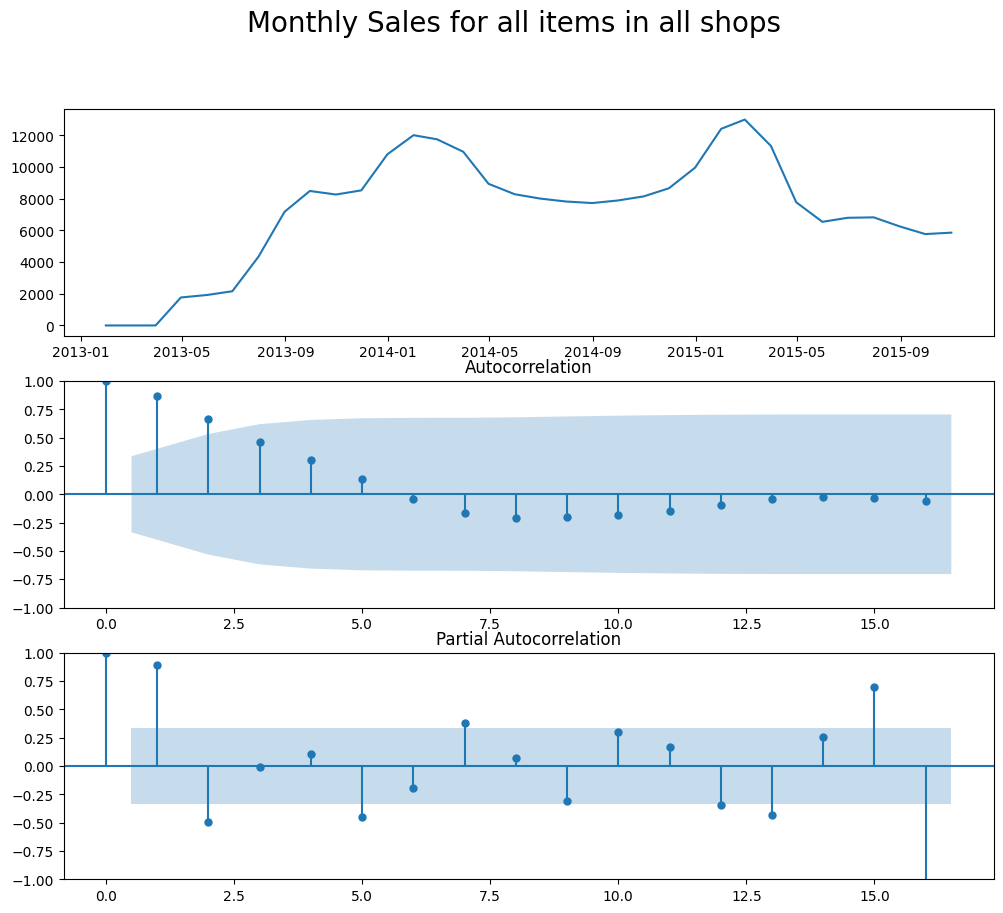

In [235]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: 299 Series Temporales diferentes tendríamos que entrenar 299 ARIMAs. En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

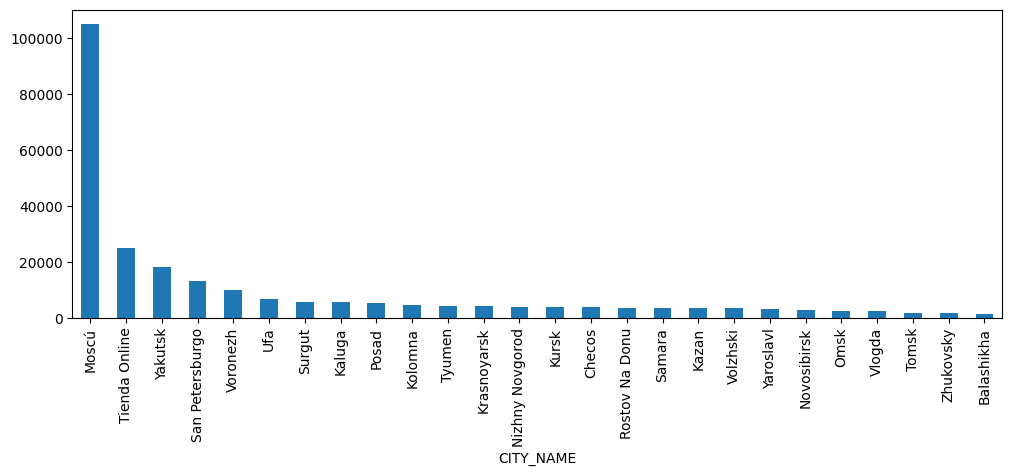

In [236]:
(
    full_df.
    groupby(["CITY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

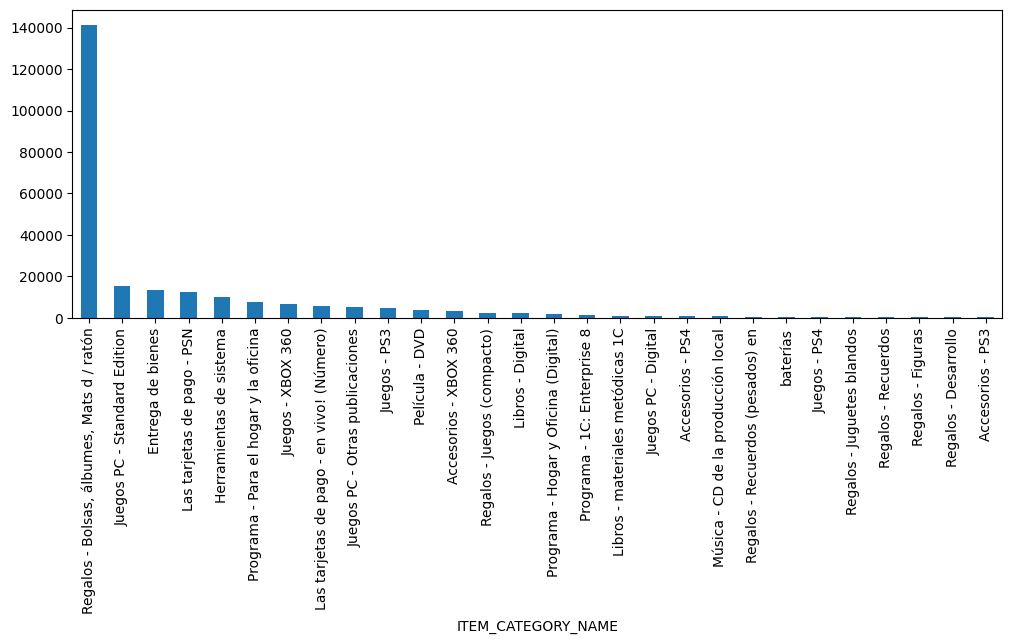

In [237]:
(
    full_df.
    groupby(["ITEM_CATEGORY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene 299 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [238]:
full_df.sample(5).T

,2060,2211,10039,6128,8503
DATE,2013-07-31 00:00:00,2013-08-31 00:00:00,2015-10-31 00:00:00,2014-09-30 00:00:00,2015-05-31 00:00:00
UNIQUE_ID,57-4870,3-17717,31-9355,31-3331,31-16169
MONTHLY_SALES,0.0,0.333333,27.333333,15.0,8.666667
MONTHLY_REVENUE,5593.0,1235.0,0.0,2797.0,1196.0
UNIQUE_DAYS_WITH_SALES,4.0,1.0,0.0,4.0,3.0
TOTAL_TRANSACTIONS,4.0,1.0,0.0,4.0,3.0
MONTHLY_MEAN_PRICE,799.0,1235.0,349.0,699.25,299.0
CITY_NAME,Yakutsk,Balashikha,Moscú,Moscú,Moscú
CITY_ID,23.0,0.0,7.0,7.0,7.0
SHOP_NAME,"Yakutsk Ordzhonikidze, 56","Balashikha TRC ""Octubre-Kinomir""","centro comercial de Moscú ""Semenov""","centro comercial de Moscú ""Semenov""","centro comercial de Moscú ""Semenov"""


In [239]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(2)
    )
    
    return gb_df_

In [240]:
"DATE_ITEM_ID_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG2"

'DATE_ITEM_ID_ITEM_CATEGORY_ID_SHOP_ID_MONTHLY_SALES_SUM_LAG2'

In [241]:
ventas_total_por_tienda_y_item_category = full_df.groupby(["DATE", "SHOP_ID", "ITEM_CATEGORY_ID"])["MONTHLY_SALES"].sum().reset_index()

In [242]:
gb_ = full_df.groupby(["SHOP_ID", "ITEM_CATEGORY_ID"])["UNIQUE_ID"].nunique()
gb_[gb_ != 1]

SHOP_ID  ITEM_CATEGORY_ID
6        35                   3
12       9                    4
15       30                   2
         75                   2
19       30                   2
22       49                   4
         73                   3
         75                   2
24       30                   3
         75                   4
25       6                    2
         19                   2
         23                   2
         28                   2
         30                   6
         35                   3
         55                   2
         65                   4
28       6                    2
         19                   4
         23                   3
         28                   2
         30                   5
         35                   3
         65                   2
31       6                    2
         19                   3
         20                   2
         23                   2
         28                   2
         30   

In [243]:
ts_ = ventas_total_por_tienda_y_item_category[
    (ventas_total_por_tienda_y_item_category["SHOP_ID"] == 12) &
    (ventas_total_por_tienda_y_item_category["ITEM_CATEGORY_ID"] ==  9)
]

In [244]:
# full_df[["UNIQUE_ID", "SHOP_ID", "ITEM_CATEGORY_ID"]].drop_duplicates()

In [245]:
ts_.head(3)

,DATE,SHOP_ID,ITEM_CATEGORY_ID,MONTHLY_SALES
18,2013-01-31,12,9,0.0
196,2013-02-28,12,9,0.0
374,2013-03-31,12,9,0.0


In [246]:
sample_target = full_df[full_df["UNIQUE_ID"] == "12-11369"][["DATE", "UNIQUE_ID", "SHOP_ID", "ITEM_CATEGORY_ID", "MONTHLY_SALES"]]
sample_target.head(3)

,DATE,UNIQUE_ID,SHOP_ID,ITEM_CATEGORY_ID,MONTHLY_SALES
3,2013-01-31,12-11369,12,9,0.0
302,2013-02-28,12-11369,12,9,0.0
601,2013-03-31,12-11369,12,9,0.0


In [247]:
print(sample_target.shape)
sample_target = pd.merge(
    left = sample_target,
    right = ts_,
    how = "left",
    on = ["DATE", "SHOP_ID", "ITEM_CATEGORY_ID"]
)
print(sample_target.shape)

(34, 5)
(34, 6)


In [248]:
42/145

0.2896551724137931

In [249]:
sample_target["MONTHLY_SALES_y_LAG_2"] = sample_target["MONTHLY_SALES_y"].shift(2)
sample_target

,DATE,UNIQUE_ID,SHOP_ID,ITEM_CATEGORY_ID,MONTHLY_SALES_x,MONTHLY_SALES_y,MONTHLY_SALES_y_LAG_2
0,2013-01-31,12-11369,12,9,0.000000,0.000000,NaN
1,2013-02-28,12-11369,12,9,0.000000,0.000000,NaN
2,2013-03-31,12-11369,12,9,0.000000,0.000000,0.000000
3,2013-04-30,12-11369,12,9,47.000000,170.333333,0.000000
4,2013-05-31,12-11369,12,9,43.000000,168.000000,0.000000
5,2013-06-30,12-11369,12,9,32.000000,147.000000,170.333333
6,2013-07-31,12-11369,12,9,22.666667,119.000000,168.000000
7,2013-08-31,12-11369,12,9,18.666667,100.000000,147.000000
8,2013-09-30,12-11369,12,9,23.333333,110.333333,119.000000
9,2013-10-31,12-11369,12,9,27.333333,107.666667,100.000000


In [250]:
# full_df.groupby(["DATE", "ITEM_CATEGORY_ID", "SHOP_ID"][1:]).get_group((71, 11))["MONTHLY_SALES"].shift(2)

In [251]:
vars_ts_item_id = build_ts_vars(
  full_df = full_df,
  gb_list = ["DATE", "SHOP_ID", "ITEM_ID"],
  target_column = "MONTHLY_SALES",
  agg_func = np.sum,
  agg_func_name = "SUM"
   
)

vars_ts_item_id.sample(10)

DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM


,DATE,SHOP_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG2
3473,2013-12-31,31,20949,972.333333,856.333333
7607,2015-02-28,28,17717,58.666667,44.333333
6908,2014-12-31,15,4178,12.333333,12.666667
8103,2015-04-30,15,3732,8.000000,7.333333
9175,2015-07-31,42,7894,3.333333,2.000000
4127,2014-02-28,53,17717,0.000000,0.333333
197,2013-01-31,39,20949,0.000000,NaN
7618,2015-02-28,31,3331,2.666667,5.666667
361,2013-02-28,22,13370,0.000000,NaN
6712,2014-11-30,28,20949,443.333333,498.333333


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [252]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_item_id, on = ["DATE", "SHOP_ID", "ITEM_ID"], how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [253]:
full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [254]:
full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")
full_df["MONTHLY_SALES"] = np.clip(full_df["MONTHLY_SALES"], 0, 30)

In [255]:
full_df.columns.tolist()

['DATE',
 'UNIQUE_ID',
 'MONTHLY_SALES',
 'MONTHLY_REVENUE',
 'UNIQUE_DAYS_WITH_SALES',
 'TOTAL_TRANSACTIONS',
 'MONTHLY_MEAN_PRICE',
 'CITY_NAME',
 'CITY_ID',
 'SHOP_NAME',
 'SHOP_ID',
 'ITEM_CATEGORY_NAME',
 'ITEM_CATEGORY_ID',
 'ITEM_NAME',
 'ITEM_ID',
 'DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM',
 'DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG2']

In [256]:
COLUMNS_TO_DROP = [
    'MONTHLY_REVENUE',
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'MONTHLY_MEAN_PRICE',
    'CITY_NAME',
    'SHOP_NAME',
    'ITEM_CATEGORY_NAME',
    'ITEM_NAME'
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [257]:
full_df.set_index("UNIQUE_ID", inplace = True)

In [258]:
full_df.sample(5)

,DATE,MONTHLY_SALES,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG2
UNIQUE_ID,,,,,,,,
22-4178,2015-05-31,7.000000,7.0,22,75,4178,7.000000,7.000000
25-3734,2014-07-31,12.666667,7.0,25,23,3734,12.666667,17.000000
19-20949,2013-08-31,30.000000,6.0,19,71,20949,120.666667,0.000000
55-13097,2015-05-31,30.000000,16.0,55,34,13097,89.333333,108.666667
31-1905,2014-11-30,8.666667,7.0,31,30,1905,8.666667,8.666667


In [260]:
# Eliminamos una variable autoexplicativa que suma las ventas mensuales por categoría por mes.
# Por tanto, el target está contenido allí, y eso no puede estar contenido en el conjunto train

full_df.drop("DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM", axis=1, inplace = True)

In [261]:
train_index = sorted(list(full_df["DATE"].unique()))[:-2]

valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]

test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

In [262]:
train_index

[numpy.datetime64('2013-01-31T00:00:00.000000000'),
 numpy.datetime64('2013-02-28T00:00:00.000000000'),
 numpy.datetime64('2013-03-31T00:00:00.000000000'),
 numpy.datetime64('2013-04-30T00:00:00.000000000'),
 numpy.datetime64('2013-05-31T00:00:00.000000000'),
 numpy.datetime64('2013-06-30T00:00:00.000000000'),
 numpy.datetime64('2013-07-31T00:00:00.000000000'),
 numpy.datetime64('2013-08-31T00:00:00.000000000'),
 numpy.datetime64('2013-09-30T00:00:00.000000000'),
 numpy.datetime64('2013-10-31T00:00:00.000000000'),
 numpy.datetime64('2013-11-30T00:00:00.000000000'),
 numpy.datetime64('2013-12-31T00:00:00.000000000'),
 numpy.datetime64('2014-01-31T00:00:00.000000000'),
 numpy.datetime64('2014-02-28T00:00:00.000000000'),
 numpy.datetime64('2014-03-31T00:00:00.000000000'),
 numpy.datetime64('2014-04-30T00:00:00.000000000'),
 numpy.datetime64('2014-05-31T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-31T00:00:00.000000000'),
 numpy.datet

In [263]:
valida_index

[numpy.datetime64('2015-09-30T00:00:00.000000000')]

In [264]:
test_index

[numpy.datetime64('2015-10-31T00:00:00.000000000')]

In [265]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['MONTHLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['MONTHLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['MONTHLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['MONTHLY_SALES']

In [266]:
X_train.head(10)

,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG2
UNIQUE_ID,,,,,
11-20949,25.0,11,71,20949,NaN
11-4181,25.0,11,75,4181,NaN
12-11365,16.0,12,9,11365,NaN
12-11369,16.0,12,9,11369,NaN
12-11370,16.0,12,9,11370,NaN
12-11373,16.0,12,9,11373,NaN
12-482,16.0,12,73,482,NaN
14-17717,3.0,14,79,17717,NaN
14-20949,3.0,14,71,20949,NaN


<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning.

In [267]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:11.09272	validation_1-rmse:9.71796
[1]	validation_0-rmse:8.77997	validation_1-rmse:7.11137
[2]	validation_0-rmse:7.36704	validation_1-rmse:5.53247
[3]	validation_0-rmse:6.54740	validation_1-rmse:4.60087
[4]	validation_0-rmse:6.08684	validation_1-rmse:4.12571
[5]	validation_0-rmse:5.81469	validation_1-rmse:3.92850
[6]	validation_0-rmse:5.67771	validation_1-rmse:3.88014
[7]	validation_0-rmse:5.59175	validation_1-rmse:3.92443
[8]	validation_0-rmse:5.54017	validation_1-rmse:3.95185
[9]	validation_0-rmse:5.50180	validation_1-rmse:3.98053
[10]	validation_0-rmse:5.47831	validation_1-rmse:3.99131
[11]	validation_0-rmse:5.45804	validation_1-rmse:4.00923
[12]	validation_0-rmse:5.44218	validation_1-rmse:4.02701
[13]	validation_0-rmse:5.43055	validation_1-rmse:4.04685
[14]	validation_0-rmse:5.42174	validation_1-rmse:4.06074
[15]	validation_0-rmse:5.40665	validation_1-rmse:4.05100
[16]	validation_0-rmse:5.39114	validation_1-rmse:4.05115


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [268]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2023_04_18_20_09_31.dat


<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

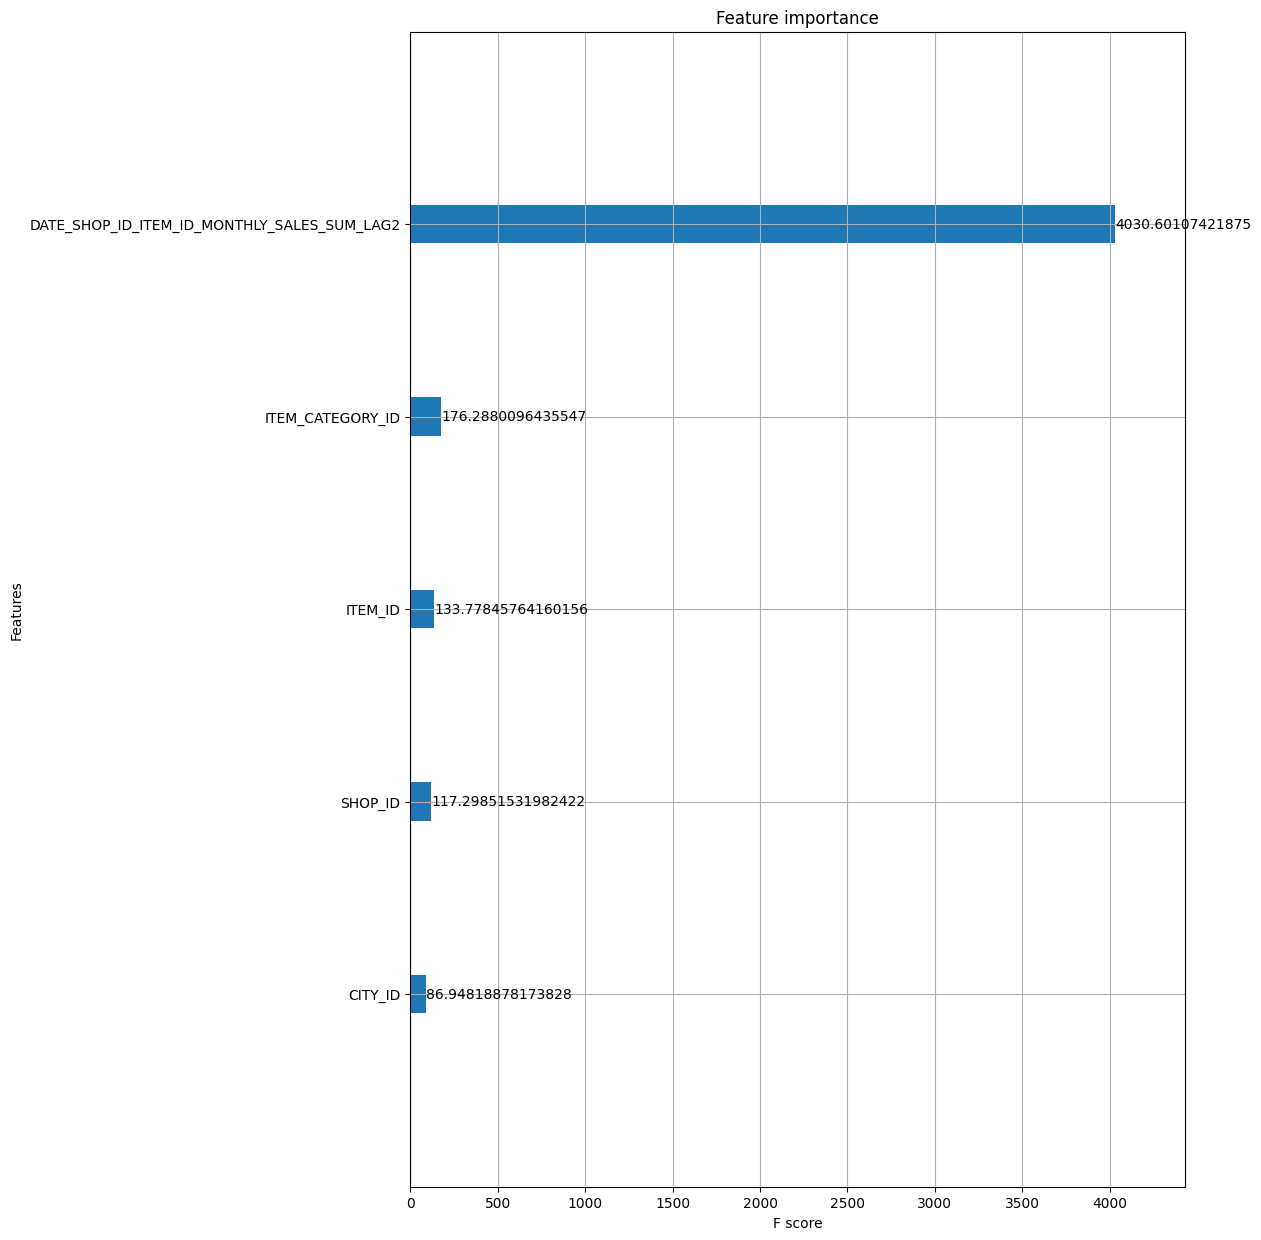

In [269]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y obtener el submit.

In [270]:
last_trained_model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

In [271]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = np.sqrt(mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

3.8801409619200085

In [272]:
X_test

,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG2
UNIQUE_ID,,,,,
11-20949,25.0,11,71,20949,29.333333
11-4181,25.0,11,75,4181,3.666667
12-11365,16.0,12,9,11365,26.000000
12-11369,16.0,12,9,11369,153.666667
12-11370,16.0,12,9,11370,267.666667
...,...,...,...,...,...
6-5823,22.0,6,35,5823,2.666667
6-7856,22.0,6,28,7856,3.666667
7-17717,22.0,7,79,17717,27.666667


In [273]:
if "SALES_PREDICTED" in X_test.columns:
    X_test.drop("SALES_PREDICTED", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["SALES_PREDICTED"] = np.clip(Y_test_predict, 0, 30)

In [274]:
Y_valida

UNIQUE_ID
11-20949    21.666667
11-4181      5.333333
12-11365    10.000000
12-11369    30.000000
12-11370    30.000000
              ...    
6-5823       2.000000
6-7856       4.666667
7-17717     24.000000
7-20949     30.000000
7-5822       7.000000
Name: MONTHLY_SALES, Length: 299, dtype: float64

In [275]:
Y_test_predict

array([24.115509 ,  4.11425  , 23.406303 , 27.5311   , 27.5311   ,
       27.5311   ,  6.878549 , 17.103453 , 27.453629 ,  6.43649  ,
       17.656013 , 27.453629 ,  5.2297487,  4.15554  ,  4.8330297,
        8.645086 , 17.559889 , 10.397774 , 19.202791 , 27.3313   ,
        7.1234717,  7.445634 ,  4.3015103, 16.003803 , 27.3313   ,
        4.3015103,  8.224187 ,  4.3015103, 11.202437 , 27.3313   ,
        5.2297487,  4.15554  ,  7.030996 ,  9.875247 , 19.195118 ,
       27.42429  ,  4.374231 ,  4.977313 , 18.911215 , 27.3313   ,
        9.781258 ,  3.6554518, 13.436793 ,  7.717494 ,  9.0829525,
       12.934521 ,  8.716099 ,  5.3661656, 12.822761 , 20.406536 ,
        5.4130497,  3.696741 ,  4.046518 ,  2.6602647,  8.159889 ,
       17.471931 ,  6.352122 ,  4.977313 ,  3.8427114,  7.0539055,
        4.192488 ,  4.9111342,  4.5248804,  8.73938  ,  4.9111342,
        8.73938  ,  6.793352 , 20.008125 ,  3.696741 , 27.42429  ,
        6.16822  ,  4.046518 ,  4.046518 ,  4.046518 ,  4.1924

In [276]:
X_test.reset_index(inplace = True)

In [277]:
(
    X_test[["UNIQUE_ID", "SALES_PREDICTED"]]
    .rename(columns = {"UNIQUE_ID":"unique_id", "SALES_PREDICTED":"sales"})
    .to_csv("submission.csv", index = False)
)

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

A continuación dejamos algunas ideas que se pueden implementar para mejorar el presente modelo:

1. Probad otras combinaciones de variables.
2. Darle más profundidad a los lags/shifts.
3. Implementar medias móviles (ojo variables autoexplicativas).
4. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
5. Añadir variables externas (relación rublo/dólar, festivos locales etc).
6. Probar otros algoritmos.
7. Tunear los hiperparametros del modelo.
